# Personalized Cancer Diagnosis

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Exploratory Data Analysis
4. Data Preprocessing <br>
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Personalized Cancer Diagnosis. Link:https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
2. **Data:** Memorial Sloan Kettering Cancer Center (MSKCC)
3. **Task:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
4. **Relevant Info:** There are nine different classes a genetic mutation can be classified on. This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical.
5. **Data includes:**
    * **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are <i>ID</i> (the id of the row used to link the mutation to the clinical evidence), <i>Gene</i> (the gene where this genetic mutation is located), <i>Variation</i> (the amino-acid change for this mutations), <i>Class</i> (1-9 the class this genetic mutation has been classified on)
    * **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## 2. Real-world/Business objective and constraints


**Objective:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
<br>
<br>**Constraints:**
<br>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## 3. Data and Libraries Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4. Data Preprocessing

In [5]:
stop_words = set(stopwords.words('english')) 

def txt_preprocessing(total_txt, index, col):
    
    if type(total_txt) is not int:
        string = ''
        total_txt = re.sub('[^a-zA-Z0-9\n]', ' ', total_txt)
        total_txt = re.sub('\s+', ' ', total_txt)
        total_txt = total_txt.lower()
        
        for word in total_txt.split():
            if not word in stop_words:
                string += word + ' '
                
        data_text[col][index] = string

In [6]:
#txt_preprocessing runner 
tic = time.time()

for index, row in data_text.iterrows():
    
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :', time.time() - tic, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 156.97053289413452 seconds


In [8]:
complete_data = pd.merge(data, data_text, on = 'ID', how = 'left')
complete_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
complete_data[complete_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [16]:
complete_data['TEXT'][complete_data['TEXT'].isnull()] = complete_data['Gene'] +' '+complete_data['Variation']

In [17]:
complete_data[complete_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [18]:
y_true = complete_data['Class'].values
complete_data.Gene = complete_data.Gene.str.replace('\s+', '_')
complete_data.Variation = complete_data.Variation.str.replace('\s+', '_')

In [19]:
train_x, test_x, train_y, test_y = train_test_split(complete_data, y_true, stratify = y_true, test_size = 0.2)
train_x = train_x.drop(['Class'], axis = 1)
test_x = test_x.drop(['Class'], axis = 1)

In [20]:
train_x.head()

,ID,Gene,Variation,TEXT
186,186,EGFR,E746V,mutations epidermal growth factor receptor egf...
1859,1859,MTOR,L2427R,renal cell carcinomas unclassified histology u...
1969,1969,CTNNB1,K335I,gain function mutations exon 3 catenin ctnnb1 ...
773,773,ERBB3,A1131T,introduction epidermal growth factor receptor ...
1948,1948,MEF2B,Y69H,mef2b gene encodes transcriptional activator f...


In [24]:
test_x.head()

,ID,Gene,Variation,TEXT
1650,1650,FLT3,V557I,mutations juxtamembrane kinase domains flt3 co...
2908,2908,NF2,Q324L,neurofibromatosis 2 nf2 tumor predisposition s...
2332,2332,JAK2,PAX5-JAK2_Fusion,philadelphia chromosome like acute lymphoblast...
664,664,CDKN2A,Deletion,determining somatic copy number alterations sc...
1012,1012,TSC2,L410R,tuberous sclerosis complex tsc autosomal domin...


In [25]:
print('Train set size:', len(train_x))
print('\nTest set size:', len(test_x))

Train set size: 2656

Test set size: 665


## 5. Exploratory Data Analysis 

In [58]:
def distribution_check(data):
    classes = np.unique(data)
    freq_counts = []
    for c in classes:
        class_count = np.array(data == c).sum()
        freq_counts.append(class_count)
    for i, c in enumerate(list(classes)):
        print('Number of Data Points in Class {} is {} ({}%)'.format(classes[i],
                                                                     freq_counts[i],
                                                                     np.round(freq_counts[i] * 100 / len(data))))
    distribution_plot(classes, freq_counts)

In [143]:
def distribution_plot(classes, freq_counts):
    sns.set()
    my_color = 'RdPu'
    plt.figure(figsize=(8, 5))
    sns.barplot(x = classes, y = freq_counts, palette="winter",)
    plt.title('Class Distribution plot')
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.show()

Number of Data Points in Class 1 is 454 (17.09%)
Number of Data Points in Class 2 is 361 (13.59%)
Number of Data Points in Class 3 is 71 (2.67%)
Number of Data Points in Class 4 is 549 (20.67%)
Number of Data Points in Class 5 is 194 (7.3%)
Number of Data Points in Class 6 is 220 (8.28%)
Number of Data Points in Class 7 is 762 (28.69%)
Number of Data Points in Class 8 is 15 (0.56%)
Number of Data Points in Class 9 is 30 (1.13%)


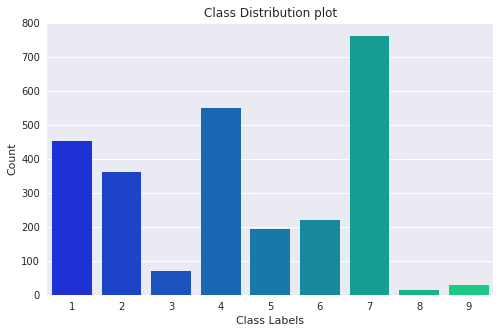

In [145]:
distribution_check(train_y)

Number of Data Points in Class 1 is 114 (17.14%)
Number of Data Points in Class 2 is 91 (13.68%)
Number of Data Points in Class 3 is 18 (2.71%)
Number of Data Points in Class 4 is 137 (20.6%)
Number of Data Points in Class 5 is 48 (7.22%)
Number of Data Points in Class 6 is 55 (8.27%)
Number of Data Points in Class 7 is 191 (28.72%)
Number of Data Points in Class 8 is 4 (0.6%)
Number of Data Points in Class 9 is 7 (1.05%)


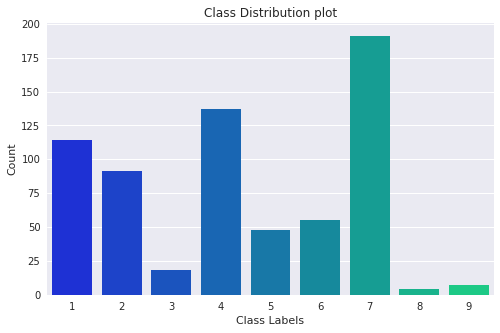

In [146]:
distribution_check(test_y)

## 6. Prediction using a 'Random' Model 

In [166]:
from sklearn.metrics import classification_report

def random_clf(ytrain, ytest):

    ytrain_dummy = np.zeros((1, len(np.unique(ytrain))))
    ytest_dummy = np.zeros((1, len(np.unique(ytest))))
    
    for i in range(len(ytrain)):
        random_probs = np.random.rand(1, len(np.unique(ytrain)))
        ytrain_dummy = np.vstack([ytrain_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Train-set using Random Model is ', log_loss(ytrain, ytrain_dummy[1:, :]))
        
    for i in range(len(ytest)):
        random_probs = np.random.rand(1, len(np.unique(ytest)))
        ytest_dummy = np.vstack([ytest_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Test-set using Random Model is ', log_loss(ytest, ytest_dummy[1:, :]))

In [167]:
random_clf(train_y, test_y)

Log-Loss on Train-set using Random Model is  2.5298344892081426


ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'multiclass'}